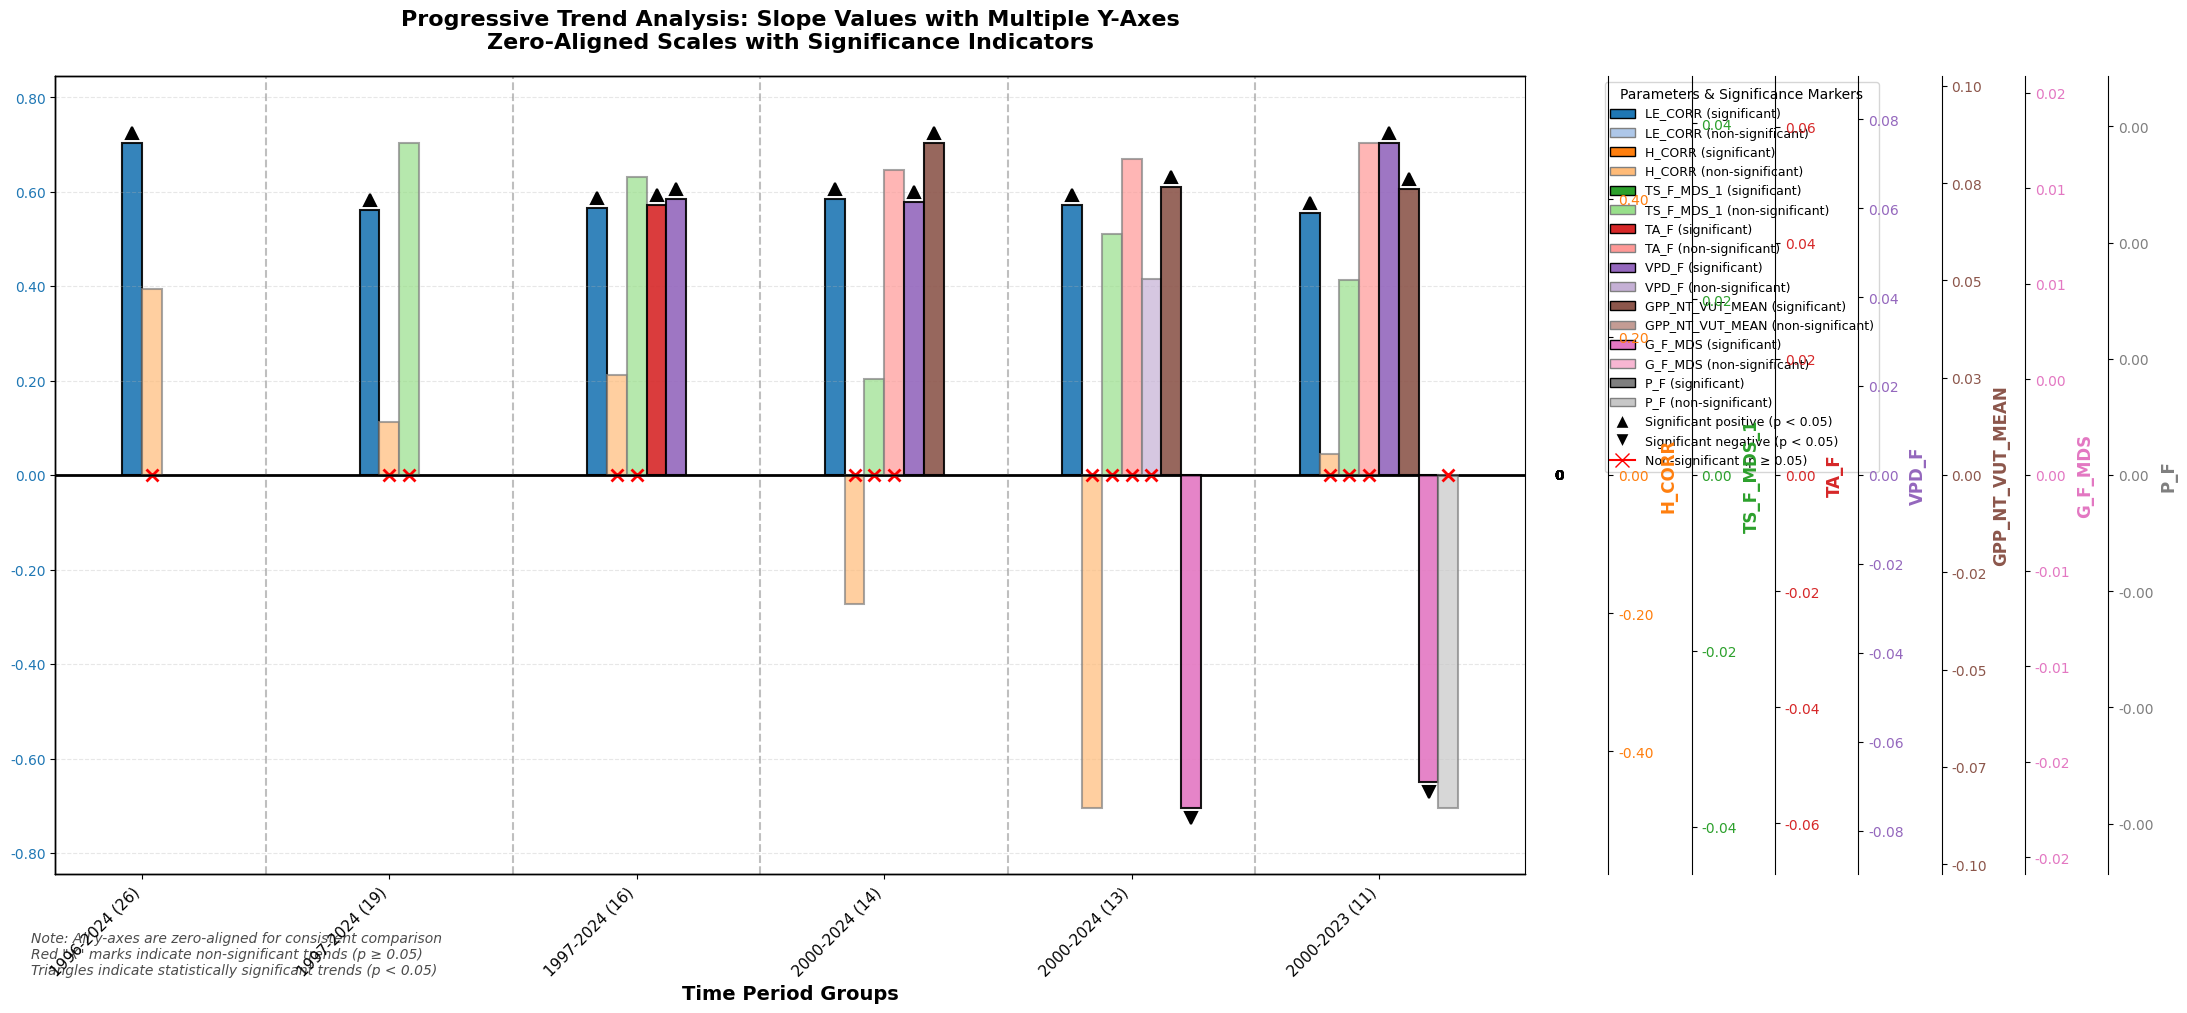

Significant Trends Summary (p < 0.05):
─────────────────────────────────────
1996-2024 (26): LE_CORR↑
1997-2024 (19): LE_CORR↑
1997-2024 (16): LE_CORR↑, TA_F↑, VPD_F↑
2000-2024 (14): LE_CORR↑, VPD_F↑, GPP_NT_VUT_MEAN↑
2000-2024 (13): LE_CORR↑, GPP_NT_VUT_MEAN↑, G_F_MDS↓
2000-2023 (11): LE_CORR↑, VPD_F↑, GPP_NT_VUT_MEAN↑, G_F_MDS↓


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

# Read the Excel file
file_path = 'progressive_trend_tables_BE-Bra_yearly.xlsx'

# Read both sheets
p_values_df = pd.read_excel(file_path, sheet_name='P-values')
slopes_df = pd.read_excel(file_path, sheet_name='Slopes')

# Clean the data - remove any rows that are entirely NaN
p_values_df = p_values_df.dropna(how='all')
slopes_df = slopes_df.dropna(how='all')

# Reset index for both dataframes
p_values_df = p_values_df.reset_index(drop=True)
slopes_df = slopes_df.reset_index(drop=True)

# Define parameters and their colors
parameters = ['LE_CORR', 'H_CORR', 'TS_F_MDS_1', 'TA_F', 'VPD_F', 'GPP_NT_VUT_MEAN', 'G_F_MDS', 'P_F']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f']
color_dict = dict(zip(parameters, colors))

# Create light versions of colors for non-significant bars
light_colors = ['#aec7e8', '#ffbb78', '#98df8a', '#ff9896', '#c5b0d5', '#c49c94', '#f7b6d2', '#c7c7c7']
light_color_dict = dict(zip(parameters, light_colors))

# Create the figure
fig, ax = plt.subplots(figsize=(18, 10))

# Get years and prepare x positions
years = slopes_df['Years'].values
x_pos = np.arange(len(years))
bar_width = 0.08
group_width = bar_width * len(parameters) + 0.1

# Create multiple y-axes, one for each parameter
axes = [ax]  # Primary axis
for i in range(1, len(parameters)):
    axes.append(ax.twinx())

# Position the additional y-axes
for i, axis in enumerate(axes[1:], 1):
    axis.spines['right'].set_position(('outward', 60 * i))
    axis.spines['right'].set_visible(True)

# First pass: find the maximum absolute value for each parameter to set consistent zero alignment
max_abs_values = {}
for param in parameters:
    values = slopes_df[param].dropna()
    if len(values) > 0:
        max_abs_values[param] = max(abs(values.min()), abs(values.max()))
    else:
        max_abs_values[param] = 0.1

# Set consistent y-limits with zero at the same relative position
for i, (param, axis) in enumerate(zip(parameters, axes)):
    max_abs = max_abs_values[param] * 1.2  # Add 20% padding
    axis.set_ylim(-max_abs, max_abs)
    axis.axhline(y=0, color='black', linestyle='-', alpha=0.7, linewidth=1)

# Plot each parameter in each year group
for year_idx, year in enumerate(years):
    # Get the variables available for this year group
    available_params = []
    for param in parameters:
        if not pd.isna(slopes_df[param].iloc[year_idx]):
            available_params.append(param)
    
    # Plot each available parameter for this year group
    for param_idx, param in enumerate(available_params):
        slope = slopes_df[param].iloc[year_idx]
        p_val = p_values_df[param].iloc[year_idx]
        
        # Calculate position within the year group
        x_position = year_idx + (param_idx - len(available_params)/2 + 0.5) * bar_width
        
        # Plot on the appropriate axis
        axis_idx = parameters.index(param)
        axis = axes[axis_idx]
        
        # Determine bar color based on significance
        if p_val < 0.05:
            bar_color = color_dict[param]
            edge_color = 'black'
            alpha_val = 0.9
        else:
            bar_color = light_color_dict[param]
            edge_color = 'gray'
            alpha_val = 0.7
        
        # Plot the bar
        bars = axis.bar(x_position, slope, bar_width, color=bar_color, 
                       alpha=alpha_val, edgecolor=edge_color, linewidth=1.5,
                       label=param if year_idx == 0 else "")
        
        # Add significance marker or cross for non-significant
        if not pd.isna(p_val):
            if p_val < 0.05:
                # Significant: add triangle marker
                marker = '^' if slope > 0 else 'v'
                marker_y = slope + (0.03 * max_abs_values[param] if slope > 0 else -0.03 * max_abs_values[param])
                axis.plot(x_position, marker_y, marker=marker, color='black', 
                         markersize=8, markeredgewidth=1.5, zorder=5)
            else:
                # Non-significant: add cross mark
                axis.plot(x_position, 0, marker='x', color='red', 
                         markersize=8, markeredgewidth=2, zorder=5)

# Customize each y-axis
for i, (param, axis) in enumerate(zip(parameters, axes)):
    axis.set_ylabel(param, fontsize=12, fontweight='bold', color=color_dict[param])
    axis.tick_params(axis='y', labelcolor=color_dict[param])
    axis.yaxis.label.set_color(color_dict[param])
    
    # Format y-axis labels
    axis.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    
    # Add zero line label
    axis.text(1.02, 0.0, '0', transform=axis.get_yaxis_transform(), 
              ha='left', va='center', color='black', fontsize=10, fontweight='bold')

# Customize the main x-axis
ax.set_xlabel('Time Period Groups', fontsize=14, fontweight='bold')
ax.set_xticks(range(len(years)))
ax.set_xticklabels(years, rotation=45, ha='right', fontsize=11)
ax.set_ylabel('')  # Remove primary y-axis label since we have multiple
ax.grid(True, alpha=0.3, linestyle='--', axis='y')
ax.axhline(y=0, color='black', linestyle='-', alpha=0.7, linewidth=2)

# Add vertical lines to separate year groups
for i in range(1, len(years)):
    ax.axvline(x=i - 0.5, color='gray', linestyle='--', alpha=0.5)

# Add title
plt.title('Progressive Trend Analysis: Slope Values with Multiple Y-Axes\nZero-Aligned Scales with Significance Indicators', 
          fontsize=16, fontweight='bold', pad=20)

# Create custom legend
legend_elements = []
for param in parameters:
    # Add significant color
    legend_elements.append(plt.Rectangle((0,0), 1, 1, facecolor=color_dict[param], 
                                       edgecolor='black', label=f"{param} (significant)"))
    # Add non-significant color
    legend_elements.append(plt.Rectangle((0,0), 1, 1, facecolor=light_color_dict[param], 
                                       edgecolor='gray', label=f"{param} (non-significant)"))

# Add markers
legend_elements.append(plt.Line2D([0], [0], marker='^', color='w', markerfacecolor='black', 
                                markersize=10, label='Significant positive (p < 0.05)'))
legend_elements.append(plt.Line2D([0], [0], marker='v', color='w', markerfacecolor='black', 
                                markersize=10, label='Significant negative (p < 0.05)'))
legend_elements.append(plt.Line2D([0], [0], marker='x', color='red', markersize=10, 
                                label='Non-significant (p ≥ 0.05)'))

ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1.05, 1), 
          fontsize=9, title='Parameters & Significance Markers')

plt.tight_layout()

# Add text explaining the structure
fig.text(0.02, 0.02, 
         'Note: All y-axes are zero-aligned for consistent comparison\n'
         'Red "X" marks indicate non-significant trends (p ≥ 0.05)\n'
         'Triangles indicate statistically significant trends (p < 0.05)',
         fontsize=10, style='italic', alpha=0.7)

plt.subplots_adjust(right=0.85, bottom=0.12)  # Make space for legend and text

plt.show()

# Print summary of significant trends
print("Significant Trends Summary (p < 0.05):")
print("─────────────────────────────────────")
for i, year in enumerate(years):
    sig_params = []
    for param in parameters:
        if not pd.isna(p_values_df[param].iloc[i]) and p_values_df[param].iloc[i] < 0.05:
            direction = "↑" if slopes_df[param].iloc[i] > 0 else "↓"
            sig_params.append(f"{param}{direction}")
    
    if sig_params:
        print(f"{year}: {', '.join(sig_params)}")
    else:
        print(f"{year}: No significant trends")

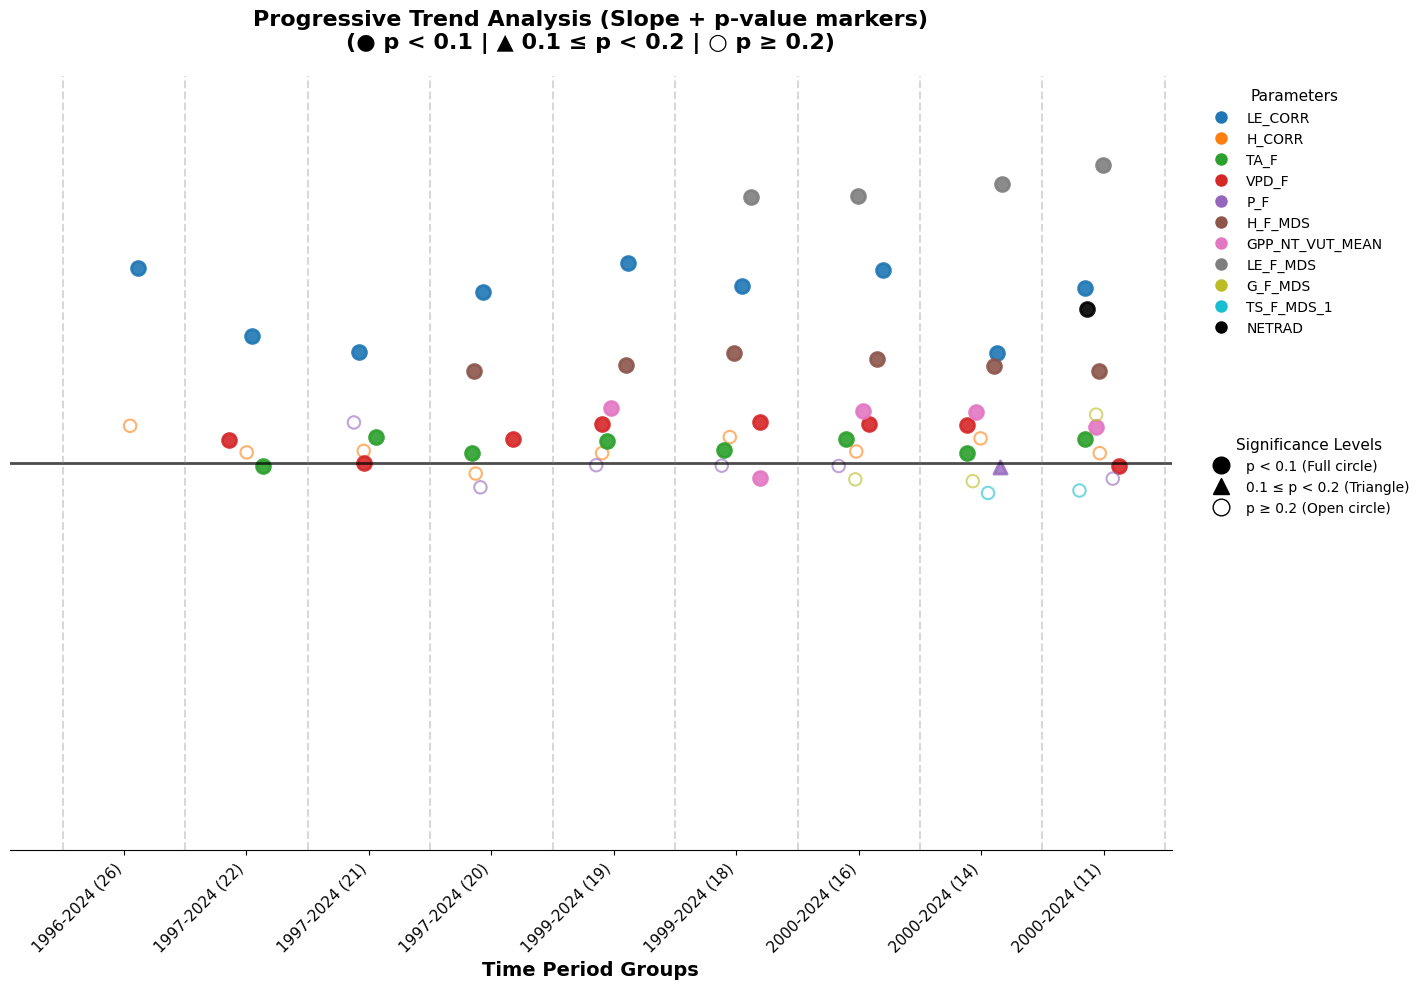

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Read the Excel file
file_path = 'progressive_trend_tables_BE-Bra_JJA.xlsx'

# Read both sheets
p_values_df = pd.read_excel(file_path, sheet_name='P-values')
slopes_df = pd.read_excel(file_path, sheet_name='Slopes')

# Clean the data - remove any rows that are entirely NaN
p_values_df = p_values_df.dropna(how='all')
slopes_df = slopes_df.dropna(how='all')

# Reset index for both dataframes
p_values_df = p_values_df.reset_index(drop=True)
slopes_df = slopes_df.reset_index(drop=True)

# Define parameters and their colors
parameters = ['LE_CORR', 'H_CORR', 'TS_F_MDS_1', 'TA_F',
              'VPD_F', 'GPP_NT_VUT_MEAN', 'G_F_MDS', 'P_F']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
          '#9467bd', '#8c564b', '#e377c2', '#7f7f7f']


# Define parameters and assign fixed colors


#color_dict = dict(zip(parameters, colors))

color_dict = {
    'LE_CORR': '#1f77b4',          # blue
    'H_CORR': '#ff7f0e',           # orange
    'TA_F': '#2ca02c',             # green
    'VPD_F': '#d62728',            # red
    'P_F': '#9467bd',              # purple
    'H_F_MDS': '#8c564b',          # brown
    'GPP_NT_VUT_MEAN': '#e377c2',  # pink
    'LE_F_MDS': '#7f7f7f',         # gray
    'G_F_MDS': '#bcbd22',          # olive
    'TS_F_MDS_1': '#17becf',       # teal
    'NETRAD': '#000000'  ,          # black
    'SWC_F_MDS_1': '#20B2AA' 
}

parameters = list(color_dict.keys())


# Create the figure
fig, ax = plt.subplots(figsize=(18, 10))

years = slopes_df['Years'].values

# Find global max slope for scaling
max_slope = 0
for param in parameters:
    if not slopes_df[param].isna().all():
        param_max = max(abs(slopes_df[param].min()), abs(slopes_df[param].max()))
        max_slope = max(max_slope, param_max)

y_limit = max_slope * 1.3

# Plot each parameter in each year group
for year_idx, year in enumerate(years):
    used_positions = []  # to track occupied y-positions for overlap check
    
    for param in parameters:
        slope = slopes_df[param].iloc[year_idx]
        p_val = p_values_df[param].iloc[year_idx]

        if pd.isna(p_val) or pd.isna(slope):
            continue

        # Initial position based on slope
        y_position = slope
        x_position = year_idx + np.random.uniform(-0.2, 0.2)

        # --- prevent overlap by nudging vertically ---
        while any(abs(y_position - yp) < 0.03 * y_limit for yp in used_positions):
            y_position += np.random.uniform(-0.02, 0.02) * y_limit
        used_positions.append(y_position)

        # Marker rules based on p-values
        if p_val < 0.1:
            marker = 'o'   # full circle
            marker_size = 100
            fill_style = 'full'
            edge_width = 2
            alpha_val = 0.9
        elif p_val < 0.2:
            marker = '^'   # triangle
            marker_size = 90
            fill_style = 'full'
            edge_width = 2
            alpha_val = 0.8
        else:
            marker = 'o'   # open circle
            marker_size = 80
            fill_style = 'none'
            edge_width = 1.5
            alpha_val = 0.6

        # Plot marker
        ax.scatter(x_position, y_position, s=marker_size,
                   c=color_dict[param] if fill_style == 'full' else 'none',
                   marker=marker, edgecolors=color_dict[param],
                   linewidths=edge_width, alpha=alpha_val)

# Customize axes
ax.set_xlabel('Time Period Groups', fontsize=14, fontweight='bold')
ax.set_xticks(range(len(years)))
ax.set_xticklabels(years, rotation=45, ha='right', fontsize=11)

# Keep consistent y scale and zero line
ax.set_ylim(-y_limit, y_limit)
ax.axhline(y=0, color='black', linestyle='-', alpha=0.7, linewidth=2)

# Remove y-axis completely
ax.set_yticks([])
ax.set_ylabel("")
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Add vertical lines to separate year groups
for i in range(len(years) + 1):
    ax.axvline(x=i - 0.5, color='gray', linestyle='--', alpha=0.3)

# Title
plt.title('Progressive Trend Analysis (Slope + p-value markers)\n'
          '(● p < 0.1 | ▲ 0.1 ≤ p < 0.2 | ○ p ≥ 0.2)',
          fontsize=16, fontweight='bold', pad=20)

# Create legends
from matplotlib.lines import Line2D

# --- Parameter legend (colors) ---
legend_elements = [
    Line2D([0], [0], marker='o', color='w',
           markerfacecolor=color_dict[param],
           markersize=10, label=param)
    for param in parameters
]

# --- Marker style legend (p-value rules) ---
marker_elements = [
    Line2D([0], [0], marker='o', color='black', markerfacecolor='black',
           markersize=12, linestyle='None', label='p < 0.1 (Full circle)'),
    Line2D([0], [0], marker='^', color='black', markerfacecolor='black',
           markersize=12, linestyle='None', label='0.1 ≤ p < 0.2 (Triangle)'),
    Line2D([0], [0], marker='o', color='black', markerfacecolor='none',
           markersize=12, linestyle='None', label='p ≥ 0.2 (Open circle)')
]

# Place parameter legend (top-right, outside)
legend1 = ax.legend(handles=legend_elements, loc='upper left',
                    bbox_to_anchor=(1.02, 1.0), fontsize=10,
                    title='Parameters', title_fontsize=11,
                    frameon=False)

# Add the first legend manually
ax.add_artist(legend1)

# Place marker style legend (below parameters, outside)
legend2 = ax.legend(handles=marker_elements, loc='upper left',
                    bbox_to_anchor=(1.02, 0.55), fontsize=10,
                    title='Significance Levels', title_fontsize=11,
                    frameon=False)

# Adjust layout to leave space for legends
plt.tight_layout(rect=[0, 0, 0.8, 1])
plt.show()


